## 「ベイズ推論による機械学習入門」
##   P.145 ガウス混合モデルに対するギブスサンプリング

In [507]:
using Distributions
using LinearAlgebra
using Plots
using Random
using PDMats

Random.seed!(1234); # 再現性のためシードを設定

## 真のモデル

In [508]:
D = 2
K = 3

μ₁_true = [5.0; 35.0]
μ₂_true = [-20.0; 10.0]
μ₃_true = [30.0; -20.0]

Σ₁_true = [
    250.0 65.0
    65.0 270.0
]

Σ₂_true = [
    125.0 -45.0
    -45.0 175.0
]

Σ₃_true = [
    210.0 -15.0
    -15.0 250.0
]

π_true = [0.45, 0.25, 0.3]

mult_gauss_true = MvNormal[
    MvNormal(μ₁_true, Σ₁_true), 
    MvNormal(μ₂_true, Σ₂_true), 
    MvNormal(μ₃_true, Σ₃_true)
]

true_model = MixtureModel(mult_gauss_true, π_true)

MixtureModel{MvNormal}(K = 3)
components[1] (prior = 0.4500): FullNormal(
dim: 2
μ: [5.0, 35.0]
Σ: [250.0 65.0; 65.0 270.0]
)

components[2] (prior = 0.2500): FullNormal(
dim: 2
μ: [-20.0, 10.0]
Σ: [125.0 -45.0; -45.0 175.0]
)

components[3] (prior = 0.3000): FullNormal(
dim: 2
μ: [30.0, -20.0]
Σ: [210.0 -15.0; -15.0 250.0]
)



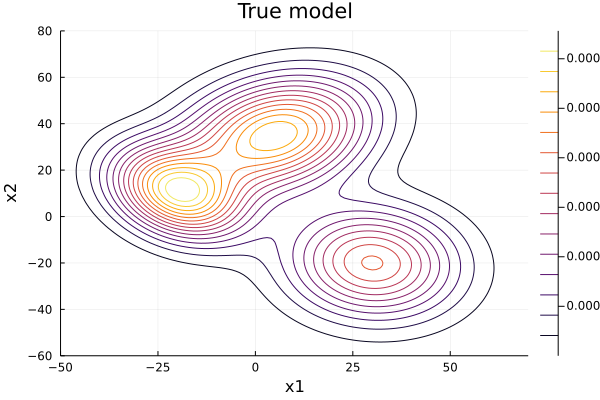

In [509]:
contour(-50:70, -60:80, (x, y) -> pdf(true_model, [x, y]), title="True model", xlabel="x1", ylabel="x2")

## 観測データの生成

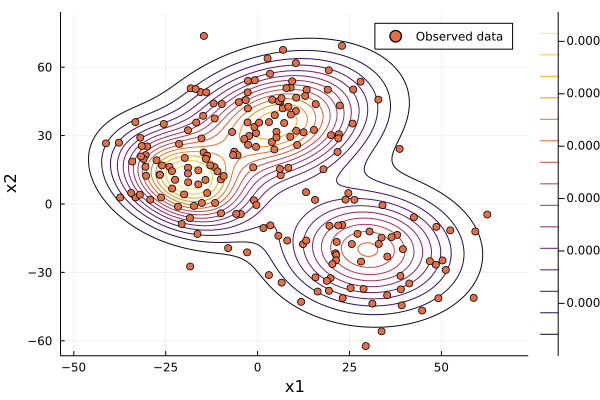

In [513]:
N = 200
mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, N)
cluster_num = mapslices(argmax, S_obs, dims=1)

μ_obs = [
    [μ₁_true]
    [μ₂_true]
    [μ₃_true]
]

Σ_obs = [
    [Σ₁_true]
    [Σ₂_true]
    [Σ₃_true]
]

data = zeros(D, N)
for n in 1:N
    k = cluster_num[n]
    mult_gauss_obs = MvNormal(μ_obs[k], Σ_obs[k])
    data[:, n] = rand(mult_gauss_obs)
end

contour(-50:70, -60:80, (x, y) -> pdf(true_model, [x, y]), xlabel="x1", ylabel="x2")
scatter!(data[1, :], data[2, :], label="Observed data")

クラスターごとに色を変えて表示する。

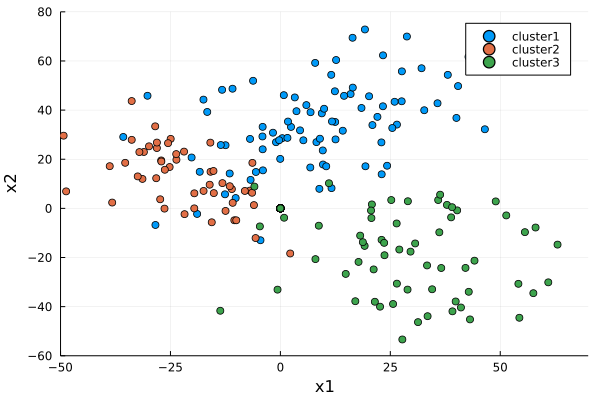

In [514]:
each_cluster = [zeros(D, N), zeros(D, N), zeros(D, N)]
for n in 1:N
    k = cluster_num[n]
    mult_gauss_obs = MvNormal(μ_obs[k], Σ_obs[k])
    each_cluster[k][:, n] = rand(mult_gauss_obs) 
end

p = plot(xlabel="x1", ylabel="x2", xlim=(-50,70), ylim=(-60,80))
for k in 1:K
    scatter!(p, each_cluster[k][1, :], each_cluster[k][2, :], label="cluster$k")
end
p

## ギブスサンプリング

In [515]:
N = 200
D = 2
K = 3
max_iter = 100

β_sample = zeros(max_iter + 1, K)
m_sample = zeros(D, K, max_iter + 1)
ν_sample = zeros(max_iter + 1, K)
W_sample = zeros(D, D, K, max_iter + 1)
α_sample = zeros(max_iter + 1, K)

μ_sample = zeros(K, D, max_iter + 1)
Λ_sample = zeros(D, D, K, max_iter + 1)
π_sample = zeros(max_iter + 1, K)

# 事前分布のパラメータの初期値を設定
β_sample[1, :] = ones(K)
ν_sample[1, :] = [2.0; 2.0; 2.0]
α_sample[1, :] = ones(K)

for k in 1:K
    W_sample[:, :, k, 1] = Matrix{Float64}(I, D, D)
end

### パラメータ$\boldsymbol \Lambda$、$\boldsymbol \alpha$のサンプルに初期値を設定

In [517]:
for k in 1:K
    wis = Wishart(ν_sample[1, k], W_sample[:, :, k, 1])
    Λ_sample[:, :, k, 1] = rand(wis)
end

Λ_sample[:, :, :, 1:2]

2×2×3×2 Array{Float64, 4}:
[:, :, 1, 1] =
 4.57406  1.29628
 1.29628  1.2679

[:, :, 2, 1] =
  1.34498   -0.597986
 -0.597986   0.277406

[:, :, 3, 1] =
 6.21486  3.70967
 3.70967  6.61357

[:, :, 1, 2] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 2] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 2] =
 0.0  0.0
 0.0  0.0

In [519]:
dir = Dirichlet(α_sample[1, :])
π_sample[1, :] = rand(dir)

π_sample[1:3, :]

3×3 Matrix{Float64}:
 0.099259  0.592296  0.308444
 0.0       0.0       0.0
 0.0       0.0       0.0

### パラメータ$\boldsymbol \mu$のサンプルに初期値を設定

In [520]:
for k in 1:K
    mult_gauss = MvNormal(m_sample[:, k, 1], PDMat(Symmetric(inv(β_sample[1, k] * Λ_sample[:, :, k, 1]))))
    μ_sample[k, :, 1] = rand(mult_gauss)
end

μ_sample[:, :, 1:2]

3×2×2 Array{Float64, 3}:
[:, :, 1] =
 -0.338224    0.0837186
 -2.96688    -5.87544
 -0.0904181   0.0251898

[:, :, 2] =
 0.0  0.0
 0.0  0.0
 0.0  0.0

### 潜在変数の事後分布のパラメータ$\boldsymbol \eta$の計算

In [521]:
η_ = zeros(N, K)
for n in 1:N
    for k in 1:K
        η_[n, k] = (data'[n, :] - μ_sample[k, :, 1])' * Λ_sample[:, :, k, 1] * (data'[n, :] - μ_sample[k, :, 1])
                    + 0.5 * log(det(Λ_sample[:, :, k, 1]))
                    + log(π_sample[1, k])
    end
end

η_[1:5, :]

5×3 Matrix{Float64}:
 1309.87    94.9861   5775.48
 7091.27   168.145   19172.1
 9115.98   102.086   33535.7
 4171.92  4479.21    17458.9
 3750.05    98.0302  14800.2

In [522]:
η = η_ ./ sum(η_, dims=2)　# 正規化

η[1:5, :]

5×3 Matrix{Float64}:
 0.182425  0.0132286   0.804347
 0.268289  0.00636155  0.72535
 0.213221  0.00238778  0.784391
 0.159782  0.171551    0.668666
 0.201094  0.00525679  0.79365

### 潜在変数$\boldsymbol S$の事後分布をサンプリング

In [523]:
s_sample = zeros(N, K)
for n in 1:N
    cat = Multinomial(1, η[n, :])
    s_sample[n, :] = rand(cat)
end

s_sample[1:5, :]

5×3 Matrix{Float64}:
 0.0  0.0  1.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0

### パラメータ$\boldsymbol \mu$の事後分布のパラメータを計算

In [524]:
β_sample[2, :] = sum(s_sample, dims=1) + β_sample[1, :]'

β_sample[1:3, :]

3×3 Matrix{Float64}:
  1.0   1.0    1.0
 45.0  20.0  138.0
  0.0   0.0    0.0

In [525]:
for k in 1:K
    m_sample[:, k, 2] = (sum(s_sample[n, k] * data'[n, :] for n in 1:N) + β_sample[1, k] * m_sample[:, k, 1]) ./ β_sample[2, k]
end

m_sample[:, :, 1:3]

2×3×3 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 8.64923   6.50279   2.6759
 7.26173  -4.57337  14.8591

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0

### パラメータ$\boldsymbol \Lambda$の事後分布のパラメータを計算

In [526]:
ν_sample[2, :] = sum(s_sample, dims=1) + ν_sample[1, :]'

ν_sample[1:3, :]

3×3 Matrix{Float64}:
  2.0   2.0    2.0
 46.0  21.0  139.0
  0.0   0.0    0.0

In [527]:
for k in 1:K
    W_sample[:, :, k, 2] = inv(sum(s_sample[n, 1] * data'[n, :] * data[:, n]' for n in 1:N)
                           + β_sample[1, 1] * m_sample[:, 1, 1] * m_sample[:, 1, 1]'
                           - β_sample[2, 1] * m_sample[:, 1, 2] .* m_sample[:, 1, 2]'
                           + inv(W_sample[:, :, k, 1]))
end

W_sample[:, :, :, 2]

2×2×3 Array{Float64, 3}:
[:, :, 1] =
 4.14309e-5  2.05537e-5
 2.05537e-5  3.77725e-5

[:, :, 2] =
 4.14309e-5  2.05537e-5
 2.05537e-5  3.77725e-5

[:, :, 3] =
 4.14309e-5  2.05537e-5
 2.05537e-5  3.77725e-5

### パラメータ$\boldsymbol \Lambda$の事後分布をサンプリング

In [528]:
for k in 1:K
    wis = Wishart(ν_sample[2, k], W_sample[:, :, k, 2])
    Λ_sample[:, :, k, 2] = rand(wis)
end

Λ_sample[:, :, :, 1:2]

2×2×3×2 Array{Float64, 4}:
[:, :, 1, 1] =
 4.57406  1.29628
 1.29628  1.2679

[:, :, 2, 1] =
  1.34498   -0.597986
 -0.597986   0.277406

[:, :, 3, 1] =
 6.21486  3.70967
 3.70967  6.61357

[:, :, 1, 2] =
 0.00227396  0.00102569
 0.00102569  0.00160121

[:, :, 2, 2] =
 0.000684696  0.000346555
 0.000346555  0.000804825

[:, :, 3, 2] =
 0.00535097  0.00274298
 0.00274298  0.00574312

### パラメータ$\boldsymbol \mu$の事後分布をサンプリング

In [529]:
for k in 1:K
    mult_gauss = MvNormal(m_sample[:, k, 2], PDMat(Symmetric(inv(β_sample[2, k] * Λ_sample[:, :, k, 2]))))
    μ_sample[k, :, 2] = rand(mult_gauss)
end

μ_sample[:, :, 1:3]

3×2×3 Array{Float64, 3}:
[:, :, 1] =
 -0.338224    0.0837186
 -2.96688    -5.87544
 -0.0904181   0.0251898

[:, :, 2] =
 4.51613    8.67895
 9.85053  -14.3287
 2.94859   15.4912

[:, :, 3] =
 0.0  0.0
 0.0  0.0
 0.0  0.0

### 混合比率の事後分布のパラメータ$\boldsymbol \alpha$を計算

In [530]:
α_sample[2, :] = sum(s_sample, dims=1) + α_sample[1, :]'

α_sample[1:3, :]

3×3 Matrix{Float64}:
  1.0   1.0    1.0
 45.0  20.0  138.0
  0.0   0.0    0.0

### 混合比率$\boldsymbol \pi$の事後分布をサンプリング

In [531]:
dir = Dirichlet(α_sample[2, :])
π_sample[2, :] = rand(dir)

π_sample[1:3, :]

3×3 Matrix{Float64}:
 0.099259  0.592296  0.308444
 0.185163  0.146276  0.668561
 0.0       0.0       0.0

### まとめ

In [ ]:
N = 200
D = 2
K = 3
max_iter = 100

β_sample = zeros(max_iter + 1, K)
m_sample = zeros(D, K, max_iter + 1)
ν_sample = zeros(max_iter + 1, K)
W_sample = zeros(D, D, K, max_iter + 1)
α_sample = zeros(max_iter + 1, K)

μ_sample = zeros(K, D, max_iter + 1)
Λ_sample = zeros(D, D, K, max_iter + 1)
π_sample = zeros(max_iter + 1, K)

# 事前分布のパラメータの初期値を設定
β_sample[1, :] = ones(K)
ν_sample[1, :] = [2.0; 2.0; 2.0]
α_sample[1, :] = ones(K)

for k in 1:K
    W_sample[:, :, k, 1] = Matrix{Float64}(I, D, D)
end

# 
